In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.join(os.path.pardir, 'code'))
figdir = os.path.join(os.path.pardir, 'figures')

import numpy as np
import numpy.matlib
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
import control
import figurefirst as fifi

import figure_functions as ff
from simulator import LinearSystemSimulator
from observability import ObservabilityMatrix
from eiso import optimize_matrix_rows_to_state, optimize_matrix_rows_to_states, optimize_matrix_rows_to_states_iterative
from eiso import analytical_observability_gramian, calculate_condition_number, rank_test

### Define system

In [3]:
system_type = 'discrete'
measurement_type = 'linear'

# Continuous-time system
# A = np.array([[0.0, 1.0, 0.0],
#               [-1.0, -1.0, 0.0],
#               [0.0, 0.0, -1.0]])

# Equivalent discrete-time system for dt = 0.1
A = np.array([[0.9952, 0.095, 0.0],
              [-0.095, 0.9002, 0.0],
              [0.0, 0.0, 0.9048]])

B = np.zeros((A.shape[0],1))

C = np.array([[1.0, 0.0, 0.0],
              [0.0, 1.0, 0.0],
              [0.0, 0.0, 1.0]])

D = np.zeros((C.shape[0],1))

# Get sizes
n_state = A.shape[0]
n_output = C.shape[0]

### Define system simulator object

In [4]:
sys = LinearSystemSimulator(A, B, C, D,
                            system_type=system_type,
                            measurement_type=measurement_type)

### Simulate

[]

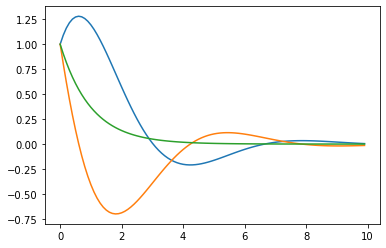

In [5]:
x0 = np.ones(n_state)

fs = 10 # match samping rate
ts = 1 / fs
T = 10

tsim = np.arange(0, T, ts).T
n_point = tsim.shape[0]
usim = 0*np.ones((len(tsim), 1))

# Simulate
nominal_state, _ = sys.simulate(x0, tsim, usim)

plt.plot(nominal_state['t'], nominal_state['x'])
plt.plot()

### Create a list of different C matrices to mimic different sensor configurations

In [6]:
def all_combinations(n_state, set_sizes=None):
    state_indices = np.arange(0, n_state, 1)
    all_combos = []
    
    if set_sizes is not None:
        n_output = set_sizes
    else:
        n_output = state_indices + 1
        
    for p in n_output: # every different size combination
        combs = itertools.combinations(state_indices, p)
        for c in combs:
            rows = np.array(c)
            C = state_indices[rows]
            all_combos.append(C)

    # Make basis vectors
    ej_list = []
    ej0 = np.zeros((1, n_state))
    for c in all_combos:
        ej = ej0.copy()
        ej[0, c] = 1
        ej_list.append(ej)
        
    return ej_list, all_combos

In [7]:
# All combinations for a single sensor
ej_list, all_combos = all_combinations(n_state)
ej_list = np.vstack(ej_list)
pd.DataFrame(np.vstack(ej_list))

,0,1,2
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,1.0,1.0,0.0
4,1.0,0.0,1.0
5,0.0,1.0,1.0
6,1.0,1.0,1.0


In [8]:
# All combination of two sensors
n_output = [1, 2]
n_combo = len(ej_list)
_, C_combos = all_combinations(n_combo, set_sizes=n_output)
n_C = len(C_combos)

In [9]:
# Get sensor data for figure color label
C_fig = []
rows_max = 2
for c in C_combos:
    if c.shape[0] < rows_max:
        C_new = np.matlib.repmat(c, 1, rows_max)
    else:
        C_new = c.copy()
    
    C_new = np.atleast_2d(C_new).T
    C_fig.append(C_new)

C_fig = np.vstack(C_fig).T
scale_color = n_C / C_fig.shape[1]

### Caclulate analytical & empirical observability matrix & Gramian for each sensor configuration

In [10]:
data = {'C': [],
        'O': [],
        'W': [],
        'CN_O': [],
        'CN_W': [],
        'Oe': [],
        'We': [],
        'CN_Oe': [],
        'CN_We': [],
        'O_rank_test': []}
        
for c in C_combos:
    # Sensor configuration
    C = np.vstack(ej_list[c])
    D = np.zeros((C.shape[0], 1))
    
    # Analytical observability matrix & Gramian
    O = control.obsv(A, C)    
    W = analytical_observability_gramian(A, C, system_type, n_derivatives=n_point)
    
    CN_O = calculate_condition_number(O, svdFlag=True, square=True)
    CN_W = calculate_condition_number(W, svdFlag=True, square=False)
    
    # Empirical observability matrix & Gramian
    sys = LinearSystemSimulator(A, B, C, D, measurement_type=measurement_type, system_type=system_type)
    Obsv = ObservabilityMatrix(sys, nominal_state['t'], nominal_state['x'], nominal_state['u'])
    Oe, deltay = Obsv.calculate_O(x0, nominal_state['t'], nominal_state['u'], eps=0.001)
    We = Oe.T @ Oe
    
    CN_Oe = calculate_condition_number(Oe, svdFlag=True, square=True)
    CN_We = calculate_condition_number(We, svdFlag=True, square=False)
    
    # Rank test on O
    O_rank_test = rank_test(O)
    
    # Store data in list
    data['C'].append(C)
    data['O'].append(O)
    data['W'].append(W)
    data['CN_O'].append(CN_O)
    data['CN_W'].append(CN_W)
    data['Oe'].append(Oe)
    data['We'].append(We)
    data['CN_Oe'].append(CN_Oe)
    data['CN_We'].append(CN_We)
    data['O_rank_test'].append(O_rank_test)
    
data['O_rank_test_all'] = np.vstack(data['O_rank_test']).T

C:\Users\bcellini\OneDrive - University of Nevada, Reno\Research\Code\github\EISO_CDC_2023\notebooks\..\code\eiso.py:365: RuntimeWarning: divide by zero encountered in scalar divide
  CN = maxE / minE


### Run E-ISO on each sensor configuration

In [11]:
data['EISO'] = np.zeros((n_state, n_C))
data['EISO_iters'] = np.zeros((n_state, n_C))

alpha = 1e-4
beta = 1e-2
sigma = 'auto'
square = True
norm = None

sv = np.arange(0, n_state, 1)
for s in sv:
    print('\nstate:', s)
    for n, o in enumerate(data['Oe']):
        print(n, end=' ')
        out = optimize_matrix_rows_to_states_iterative(o,
                                                       states=[s],
                                                       alpha=alpha,
                                                       beta=beta,
                                                       sigma=sigma,
                                                       square=square,
                                                       include_constraints=False,
                                                       norm=norm)

        data['EISO'][s, n] = out['CN_min']
        
        iters = out['iteration_index']
        if np.any(np.isnan(iters)):
            data['EISO_iters'][s, n] = np.nan
        else:
             data['EISO_iters'][s, n] = out['iteration_index'].shape[0]

print('\nDone')


state: 0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
state: 1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
state: 2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
Done


### Plot

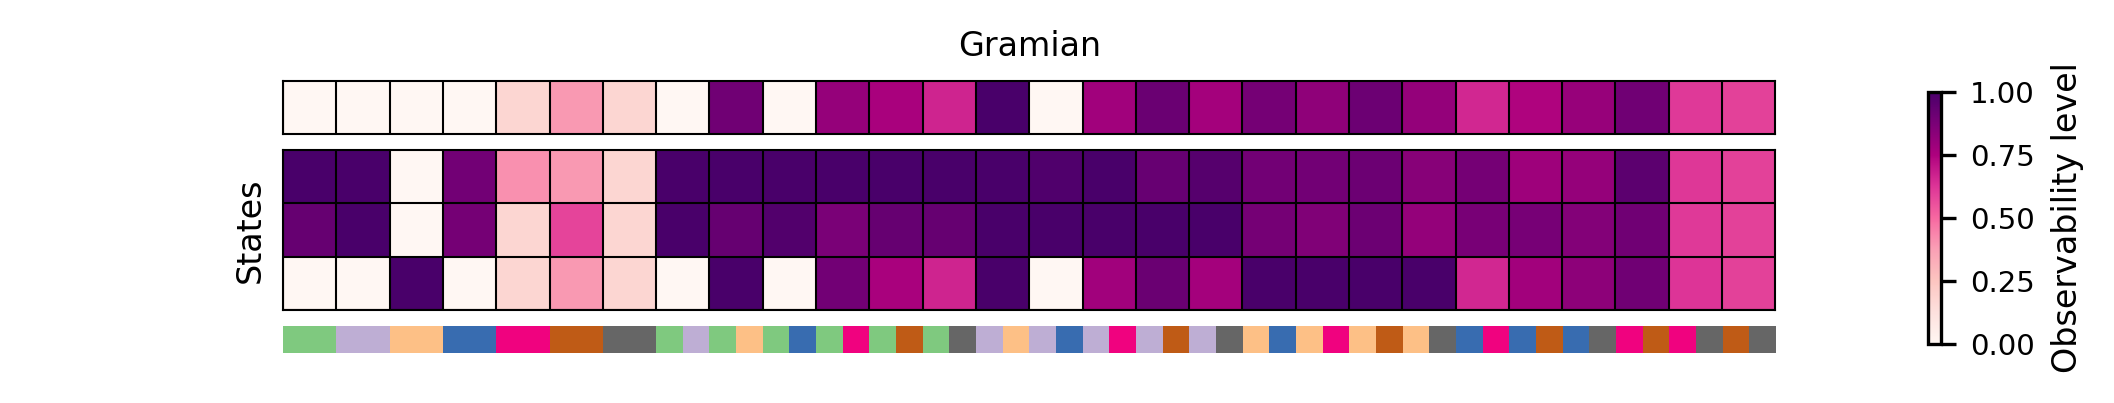

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(n_C*0.4, n_state*0.4), dpi=300, gridspec_kw={'height_ratios':[1, n_state, scale_color]})

aspect = 1

cmap = 'RdPu'
cmapr = cmap + '_r'

lim = n_C

cdata_W = data['CN_W'].copy()
cdata_W = cdata_W[0:lim]
cdata_W = np.atleast_2d(cdata_W)
cdata_W[cdata_W == np.inf] = np.nan

cdata_EISO = data['EISO'].copy()
cdata_EISO = cdata_EISO[:, 0:lim]

cnorm = 1.2*np.max([np.nanmax(cdata_W), np.nanmax(cdata_EISO)])
cdata_W = np.nan_to_num(cdata_W, nan=cnorm)
cdata_EISO = np.nan_to_num(cdata_EISO, nan=cnorm)

cdata_all = np.vstack((cdata_EISO, cdata_W))
cmax = np.max(cdata_all)
cmin = np.min(cdata_all)

# Gramian condition #
ax[0].imshow(cdata_W, cmap=cmapr, vmin=cmin, vmax=cmax, aspect=aspect)
ax[0].set_title('Gramian', fontsize=8)

# E-ISO condition #
ax[1].imshow(cdata_EISO, cmap=cmapr, vmin=cmin, vmax=cmax, aspect=aspect)
# ax[1].set_title('E-SIO', fontsize=8)

# Sensor configuration color labels
ax[2].imshow(C_fig, cmap='Accent', aspect=aspect)
fifi.mpl_functions.adjust_spines(ax[2], [])

for a in ax[0:2]:
    a.set_xticks(np.arange(0, n_C, 1) - 0.5)
    a.tick_params(axis='x', labelsize=7, direction='out', length=0)
    a.tick_params(axis='y', labelsize=7, direction='out', length=0)
    a.grid(linewidth=0.5, color='black')
    a.set_facecolor('lightgray')
    a.set_xticklabels(labels=[], fontsize=7)
    a.xaxis.set_tick_params(labelbottom=False)
    a.yaxis.set_tick_params(labelleft=False)
    
    for p in ['top','bottom','left','right']:
        a.spines[p].set_linewidth(0.5)
        a.spines[p].set_color('black')

ax[1].set_ylabel('States', fontsize=8)
ax[1].set_xlabel('C matrix', fontsize=8)

ax[0].set_yticks([])
ax[1].set_yticks(np.arange(0, n_state, 1) + 0.5)

# fifi.mpl_functions.adjust_spines(ax[2], [])

cbar_ax = fig.add_axes([0.78, 0.15, 0.01, 0.7])
fifi.mpl_functions.adjust_spines(cbar_ax, [])

cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=cbar_ax, fraction=1, pad=0, location='right')
cbar.set_label('Observability level', color='black', fontsize=8)
cbar.ax.yaxis.set_tick_params(color='k', labelsize=7)

figpath = os.path.join(figdir, r'figure_2.pdf')
plt.savefig(figpath, bbox_inches='tight')

### Binary observability from rank test

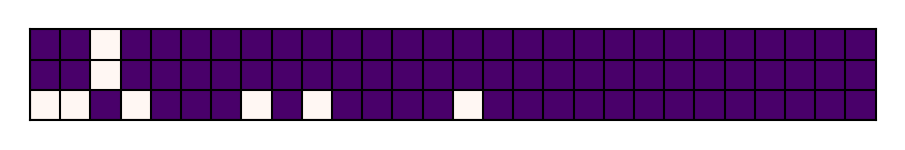

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(n_C*0.4, 1*0.4), dpi=300)
ax.imshow(data['O_rank_test_all'], cmap=cmap, aspect=aspect)

a = ax
a.set_yticks(np.arange(0, n_state, 1) + 0.5)
a.set_xticks(np.arange(0, n_C, 1) - 0.5)
a.tick_params(axis='x', labelsize=7, direction='out', length=0)
a.tick_params(axis='y', labelsize=7, direction='out', length=0)
a.grid(linewidth=0.5, color='black')
a.set_facecolor('lightgray')
a.set_xticklabels(labels=[], fontsize=7)
a.xaxis.set_tick_params(labelbottom=False)
a.yaxis.set_tick_params(labelleft=False)

for p in ['top','bottom','left','right']:
    a.spines[p].set_linewidth(0.5)
    a.spines[p].set_color('black')

### Correlation between condition # of Gramian & maximum condition number from E-ISO

In [14]:
EISO_max_CN = np.max(data['EISO'].T, axis=1)
CN_W = np.hstack(data['CN_W'])

x = EISO_max_CN.copy()
x = x[~np.isnan(x)]

y = CN_W.copy()
y = y[~np.isinf(y)]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
R2 = r_value**2
xfit = np.arange(np.min(x), np.max(x) + 1, 1)
yfit = intercept + slope*xfit

print('R^2 =', R2)
print('p =', p_value)

R^2 = 0.9946455940199684
p = 4.793617361666347e-23


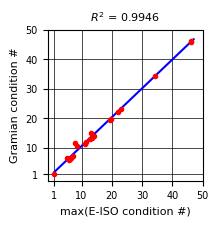

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=100)

ax.plot(xfit, yfit, 'b')
ax.plot(EISO_max_CN, data['CN_W'], '.r')

ax.set_title('$R^2$ = ' + str(np.round(R2,4)), fontsize=8)
ax.set_ylabel('Gramian condition #', fontsize=8)
ax.set_xlabel('max(E-ISO condition #)', fontsize=8)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)

axticks = np.hstack((np.array(1), np.arange(10, 51, 10)))
ax.set_xticks(axticks)
ax.set_yticks(axticks)

ax.grid(linewidth=0.5, color='black')